In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random

# Fungsi untuk mengatur random seed agar hasil bisa direproduksi
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.config.experimental.enable_op_determinism()
set_seeds()

print("Random seed telah diatur untuk memastikan hasil yang dapat direproduksi.")
print("-" * 30)


Random seed telah diatur untuk memastikan hasil yang dapat direproduksi.
------------------------------


In [2]:
import pandas as pd
import numpy as np # Umumnya tetap berguna

# URL untuk dataset univariate Anda
url_univariate = "https://raw.githubusercontent.com/adamzakys/SourceFiles/refs/heads/main/DatasetFinal/Dataset%20After%20Preprocessing/df_univariate.csv"

# Membaca CSV dan menjadikan 'Tanggal' sebagai datetime, lalu urutkan
df_uni = pd.read_csv(url_univariate, parse_dates=['Tanggal'])
df_uni = df_uni.sort_values(by='Tanggal').reset_index(drop=True)

print("df_uni (Univariate) berhasil dimuat:")
print(df_uni.head())
print(f"Bentuk df_uni: {df_uni.shape}")
print("-" * 30)

df_uni (Univariate) berhasil dimuat:
     Tanggal     Price
0 2018-01-01  0.099273
1 2018-01-02  0.111995
2 2018-01-03  0.115906
3 2018-01-04  0.116134
4 2018-01-05  0.133379
Bentuk df_uni: (2557, 2)
------------------------------


In [3]:
# Fungsi split_dataframe_minimal (tetap sama seperti sebelumnya)
def split_dataframe_minimal(df, train_ratio=0.85, val_ratio=0.10):
    """Membagi DataFrame menjadi train, val, dan test secara kronologis (minimalis)."""
    total_rows = len(df)
    train_end_idx = int(total_rows * train_ratio)
    val_end_idx = int(total_rows * (train_ratio + val_ratio))

    train_df = df.iloc[:train_end_idx]
    val_df = df.iloc[train_end_idx:val_end_idx]
    test_df = df.iloc[val_end_idx:]
    
    return train_df, val_df, test_df

# Panggil fungsi split
# Pastikan df_uni sudah dimuat dari Blok 1
if 'df_uni' in locals() and not df_uni.empty:
    train_df_unw, val_df_unw, test_df_unw = split_dataframe_minimal(df_uni)

    # Cek hasilnya dengan informasi tanggal
    print("Pembagian DataFrame berhasil (Univariate Non-Windowing):")

    if not train_df_unw.empty:
        train_start_date = train_df_unw['Tanggal'].min().strftime('%Y-%m-%d')
        train_end_date = train_df_unw['Tanggal'].max().strftime('%Y-%m-%d')
        print(f"- Training   : {train_df_unw.shape[0]} baris, dari {train_start_date} s.d. {train_end_date}")
    else:
        print(f"- Training   : {train_df_unw.shape[0]} baris")

    if not val_df_unw.empty:
        val_start_date = val_df_unw['Tanggal'].min().strftime('%Y-%m-%d')
        val_end_date = val_df_unw['Tanggal'].max().strftime('%Y-%m-%d')
        print(f"- Validation : {val_df_unw.shape[0]} baris, dari {val_start_date} s.d. {val_end_date}")
    else:
        print(f"- Validation : {val_df_unw.shape[0]} baris")

    if not test_df_unw.empty:
        test_start_date = test_df_unw['Tanggal'].min().strftime('%Y-%m-%d')
        test_end_date = test_df_unw['Tanggal'].max().strftime('%Y-%m-%d')
        print(f"- Testing    : {test_df_unw.shape[0]} baris, dari {test_start_date} s.d. {test_end_date}")
    else:
        print(f"- Testing    : {test_df_unw.shape[0]} baris")
        
else:
    print("DataFrame df_uni belum dimuat atau kosong. Pembagian data tidak dilakukan.")
    # Inisialisasi agar variabel ada jika df_uni gagal dimuat
    train_df_unw, val_df_unw, test_df_unw = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
print("-" * 30)

Pembagian DataFrame berhasil (Univariate Non-Windowing):
- Training   : 2173 baris, dari 2018-01-01 s.d. 2023-12-13
- Validation : 256 baris, dari 2023-12-14 s.d. 2024-08-25
- Testing    : 128 baris, dari 2024-08-26 s.d. 2024-12-31
------------------------------


In [4]:
import numpy as np

# Fungsi ini sekarang membuat "window"
def prepare_sequences_windowed(df, feature_cols, target_col, date_col, 
                               n_input_steps=30, n_output_steps=30):
    """
    Mempersiapkan sekuens X (data historis 30 hari) dan y (target 30 hari ke depan).
    """
    X_list, y_list, dates_X_list = [], [], []
    
    num_rows = len(df)
    for i in range(num_rows - n_input_steps - n_output_steps + 1):
        X_sample = df.iloc[i : i + n_input_steps][feature_cols].values
        y_sample = df.iloc[i + n_input_steps : i + n_input_steps + n_output_steps][target_col].values
        
        if len(X_sample) == n_input_steps and len(y_sample) == n_output_steps:
            X_list.append(X_sample)
            y_list.append(y_sample)
            dates_X_list.append(df.iloc[i + n_input_steps - 1][date_col]) 
            
    X_np = np.array(X_list, dtype=np.float32)
    y_np = np.array(y_list, dtype=np.float32)
    dates_X_np = np.array(dates_X_list)
    
    return X_np, y_np, dates_X_np

# --- Aplikasi untuk Skenario Univariat (Windowing) ---

# Definisikan parameter
feature_cols_uv = ['Price'] 
target_col_name = 'Price'
date_col_name = 'Tanggal'
N_INPUT_DAYS = 30
N_OUTPUT_DAYS = 30 

# Pastikan DataFrame hasil split tidak kosong
if 'train_df_unw' in locals() and not train_df_unw.empty:
    
    # Panggil fungsi windowing
    # --- PENAMAAN VARIABEL DISESUAIKAN ---
    X_train_lstm_unw, y_train_unw, dates_X_train_unw = prepare_sequences_windowed(
        train_df_unw, feature_cols_uv, target_col_name, date_col_name, 
        n_input_steps=N_INPUT_DAYS, n_output_steps=N_OUTPUT_DAYS
    )
    X_val_lstm_unw, y_val_unw, dates_X_val_unw = prepare_sequences_windowed(
        val_df_unw, feature_cols_uv, target_col_name, date_col_name, 
        n_input_steps=N_INPUT_DAYS, n_output_steps=N_OUTPUT_DAYS
    )
    X_test_lstm_unw, y_test_unw, dates_X_test_unw = prepare_sequences_windowed(
        test_df_unw, feature_cols_uv, target_col_name, date_col_name, 
        n_input_steps=N_INPUT_DAYS, n_output_steps=N_OUTPUT_DAYS
    )

    # --- BLOK RESHAPE DIHAPUS ---
    # Karena data sudah 3D dari fungsi di atas.

    print("Persiapan sekuens untuk model LSTM Univariat (Windowing) Selesai:")
    # Menampilkan bentuk data dengan nama variabel yang sudah disesuaikan
    print(f"- Training   X: {X_train_lstm_unw.shape}, y: {y_train_unw.shape}")
    print(f"- Validation X: {X_val_lstm_unw.shape}, y: {y_val_unw.shape}")
    print(f"- Testing    X: {X_test_lstm_unw.shape}, y: {y_test_unw.shape}")
else:
    print("DataFrame (train, val, atau test) kosong.")

print("-" * 30)

Persiapan sekuens untuk model LSTM Univariat (Windowing) Selesai:
- Training   X: (2114, 30, 1), y: (2114, 30)
- Validation X: (197, 30, 1), y: (197, 30)
- Testing    X: (69, 30, 1), y: (69, 30)
------------------------------


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def build_lstm_model(input_shape, output_size, num_units, dropout_rate, learning_rate):
    """Membangun arsitektur model LSTM."""
    model = Sequential([
        LSTM(num_units, return_sequences=True, input_shape=input_shape, activation='tanh'),
        Dropout(dropout_rate),
        LSTM(num_units, return_sequences=False, activation='tanh'),
        Dropout(dropout_rate),
        Dense(output_size, activation='linear')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    return model

print("Fungsi build_lstm_model berhasil direvisi (hanya menggunakan MSE).")
print("-" * 30)

Fungsi build_lstm_model berhasil direvisi (hanya menggunakan MSE).
------------------------------


In [ ]:
import itertools # Untuk membuat semua kombinasi hyperparameter

# Ruang pencarian hyperparameter (sesuai diskusi kita sebelumnya)
param_grid = {
    'units': [50, 75, 100],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64],
    'dropout_rate': [0.1, 0.2]
}

# Epochs maksimal dan patience untuk EarlyStopping
EPOCHS_MAX = 200
PATIENCE = 15

# Buat semua kombinasi dari hyperparameter
all_combinations = list(itertools.product(
    param_grid['units'],
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['dropout_rate']
))

print(f"Total kombinasi hyperparameter yang akan diuji: {len(all_combinations)}")

# List untuk menyimpan hasil dari setiap kombinasi
history_results = []

# Loop untuk grid search
for idx, params in enumerate(all_combinations):
    units, lr, batch_size, dropout = params
    
    print(f"\n--- Menguji Kombinasi {idx + 1}/{len(all_combinations)} ---")
    print(f"Params: Units={units}, LR={lr}, BatchSize={batch_size}, Dropout={dropout}")

    # Bangun model dengan hyperparameter saat ini
    # Input shape untuk univariat non-windowing adalah (1, 1)
    # y_train_unw.shape[1] adalah jumlah output (30)
    model_unw = build_lstm_model(
        input_shape=(X_train_lstm_unw.shape[1], X_train_lstm_unw.shape[2]),
        output_size=y_train_unw.shape[1],
        num_units=units,
        dropout_rate=dropout,
        learning_rate=lr
    )

    # Definisikan EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)

    # Latih model
    history = model_unw.fit(
        X_train_lstm_unw, y_train_unw,
        epochs=EPOCHS_MAX,
        batch_size=batch_size,
        validation_data=(X_val_lstm_unw, y_val_unw),
        callbacks=[early_stopping],
        verbose=0,
        shuffle=False
    )

    
    # Ambil nilai loss validasi terbaik dari history
    best_val_loss = min(history.history['val_loss'])
    stopped_epoch = early_stopping.stopped_epoch
    
    print(f"Selesai pada epoch: {stopped_epoch if stopped_epoch > 0 else EPOCHS_MAX}. Val Loss Terbaik: {best_val_loss:.6f}")

    # Simpan hasil
    history_results.append({
        'combination': idx + 1,
        'units': units,
        'learning_rate': lr,
        'batch_size': batch_size,
        'dropout_rate': dropout,
        'best_val_loss': best_val_loss,
        'stopped_epoch': stopped_epoch if stopped_epoch > 0 else EPOCHS_MAX
    })

print("\n--- Pencarian Hyperparameter Selesai ---")

# Konversi hasil ke DataFrame untuk analisis mudah
results_df = pd.DataFrame(history_results)
results_df = results_df.sort_values(by='best_val_loss', ascending=True)

print("\nTop 5 Kombinasi Hyperparameter Terbaik (berdasarkan Validation Loss):")
print(results_df.head(5).to_string())

# Simpan hasil lengkap ke CSV
results_df.to_csv('grid_search_results_univariate_nonwindowing.csv', index=False)
print("\nHasil lengkap disimpan ke 'grid_search_results_univariate_nonwindowing.csv'")

Total kombinasi hyperparameter yang akan diuji: 54

--- Menguji Kombinasi 1/54 ---
Params: Units=50, LR=0.0001, BatchSize=16, Dropout=0.1


d:\experiment after testing - Copy\Code Penelitian new\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 9.
Selesai pada epoch: 23. Val Loss Terbaik: 0.025732

--- Menguji Kombinasi 2/54 ---
Params: Units=50, LR=0.0001, BatchSize=16, Dropout=0.2
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 10.
Selesai pada epoch: 24. Val Loss Terbaik: 0.028699

--- Menguji Kombinasi 3/54 ---
Params: Units=50, LR=0.0001, BatchSize=32, Dropout=0.1
Restoring model weights from the end of the best epoch: 99.
Selesai pada epoch: 100. Val Loss Terbaik: 0.014274

--- Menguji Kombinasi 4/54 ---
Params: Units=50, LR=0.0001, BatchSize=32, Dropout=0.2
Restoring model weights from the end of the best epoch: 98.
Selesai pada epoch: 100. Val Loss Terbaik: 0.012276

--- Menguji Kombinasi 5/54 ---
Params: Units=50, LR=0.0001, BatchSize=64, Dropout=0.1
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 32.
Selesai pada epoch: 46. Val Loss Terbaik: 0.012252

--- Menguji Kombinas

In [7]:
# Pastikan history_results dari Blok 6 sudah ada dan berisi hasil
if 'history_results' in locals() and history_results:
    # Konversi hasil ke DataFrame untuk analisis mudah
    results_df = pd.DataFrame(history_results)
    
    # Urutkan DataFrame berdasarkan validation loss terbaik (terendah)
    results_df = results_df.sort_values(by='best_val_loss', ascending=True)

    print("\n--- Analisis Hasil Pencarian Hyperparameter ---")
    print("\nTop 5 Kombinasi Hyperparameter Terbaik (berdasarkan Validation Loss):")
    # Menggunakan .to_string() agar semua kolom ditampilkan dengan rapi
    print(results_df.head(5).to_string())

    # Menyimpan hasil lengkap ke file CSV untuk dokumentasi
    output_filename = 'grid_search_results_univariate_nonwindowing.csv'
    results_df.to_csv(output_filename, index=False)
    print(f"\nHasil lengkap dari 36 kombinasi disimpan ke '{output_filename}'")

else:
    print("Tidak ada hasil pencarian hyperparameter (history_results) untuk dianalisis.")
    # Inisialisasi results_df kosong jika tidak ada hasil
    results_df = pd.DataFrame()

print("-" * 30)


--- Analisis Hasil Pencarian Hyperparameter ---

Top 5 Kombinasi Hyperparameter Terbaik (berdasarkan Validation Loss):
    combination  units  learning_rate  batch_size  dropout_rate  best_val_loss  stopped_epoch
52           53    100          0.010          64           0.1       0.004548             39
17           18     50          0.010          64           0.2       0.004855             29
29           30     75          0.001          64           0.2       0.006348            100
34           35     75          0.010          64           0.1       0.006707             24
47           48    100          0.001          64           0.2       0.008373             71

Hasil lengkap dari 36 kombinasi disimpan ke 'grid_search_results_univariate_nonwindowing.csv'
------------------------------


Hasil grid search berhasil dimuat dari 'grid_search_results_univariate_nonwindowing.csv'

--- Hyperparameter Terbaik Terpilih ---
   combination  units  learning_rate  batch_size  dropout_rate  best_val_loss  stopped_epoch
0         53.0  100.0           0.01        64.0           0.1       0.004548           39.0
--------------------------------------------------

Membangun model final dengan hyperparameter terbaik...


d:\experiment after testing - Copy\Code Penelitian new\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_108 (LSTM)                 │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_109 (LSTM)                 │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,230 (485.27 KB)

 Trainable params: 124,230 (485.27 KB)

 Non-trainable params: 0 (0.00 B)


--- Memulai Pelatihan Model Final ---
Epoch 1/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0080 - mse: 0.0080
Epoch 1: val_loss improved from inf to 0.12177, saving model to final_model_univariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.1218 - val_mse: 0.1218
Epoch 2/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0248 - mse: 0.0248
Epoch 2: val_loss did not improve from 0.12177
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.1375 - val_mse: 0.1375
Epoch 3/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0229 - mse: 0.0229
Epoch 3: val_loss did not improve from 0.12177
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.1362 - val_mse: 0.1362
Epoch 4/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0249 - mse: 0.0249
Epoch 4: val_loss did not improve from 0.12177
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.1280 - val_mse: 0.1280
Epoch 5/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0238 - mse: 0.0238
Epoch 5: val_loss improved from 0.12177 to 0.06866, saving model to final_model_univariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0687 - val_mse: 0.0687
Epoch 6/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0279 - mse: 0.0279
Epoch 6: val_loss did not improve from 0.06866
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.1172 - val_mse: 0.1172
Epoch 7/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0217 - mse: 0.0217
Epoch 7: val_loss did not improve from 0.06866
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.1008 - val_mse: 0.1008
Epoch 8/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0185 - mse: 0.0185
Epoch 8: val_loss improved from 0.06866 to 0.06619, saving model to final_model_univariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0662 - val_mse: 0.0662
Epoch 9/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0158 - mse: 0.0158
Epoch 9: val_loss improved from 0.06619 to 0.03600, saving model to final_model_univariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 10/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0093 - mse: 0.0093
Epoch 10: val_loss improved from 0.03600 to 0.03269, saving model to final_model_univariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 11/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0087 - mse: 0.0087
Epoch 11: val_loss improved from 0.03269 to 0.01723, saving model to final_model_univariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 12/39
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0081 - mse: 0.0081
Epoch 12: val_loss did not improve from 0.01723
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 13/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0091 - mse: 0.0091
Epoch 13: val_loss did not improve from 0.01723
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 14/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0081 - mse: 0.0081
Epoch 14: val_loss did not improve from 0.01723
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 15/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0054 - mse: 0.0054
Epoch 15: val_loss did not improve from 0.01723
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0054 - mse

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 17/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0020 - mse: 0.0020
Epoch 17: val_loss improved from 0.01712 to 0.01467, saving model to final_model_univariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 18/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0018 - mse: 0.0018
Epoch 18: val_loss did not improve from 0.01467
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 19/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0019 - mse: 0.0019
Epoch 19: val_loss did not improve from 0.01467
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 20/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0019 - mse: 0.0019
Epoch 20: val_loss did not improve from 0.01467
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 21/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0021 - mse: 0.0021
Epoch 21: val_loss did not improve from 0.01467
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0022 - mse

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 23/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0022 - mse: 0.0022
Epoch 23: val_loss did not improve from 0.01426
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 24/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0025 - mse: 0.0025
Epoch 24: val_loss did not improve from 0.01426
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 25/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0026 - mse: 0.0026
Epoch 25: val_loss did not improve from 0.01426
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 26/39
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0027 - mse: 0.0027
Epoch 26: val_loss did not improve from 0.01426
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0027 - mse

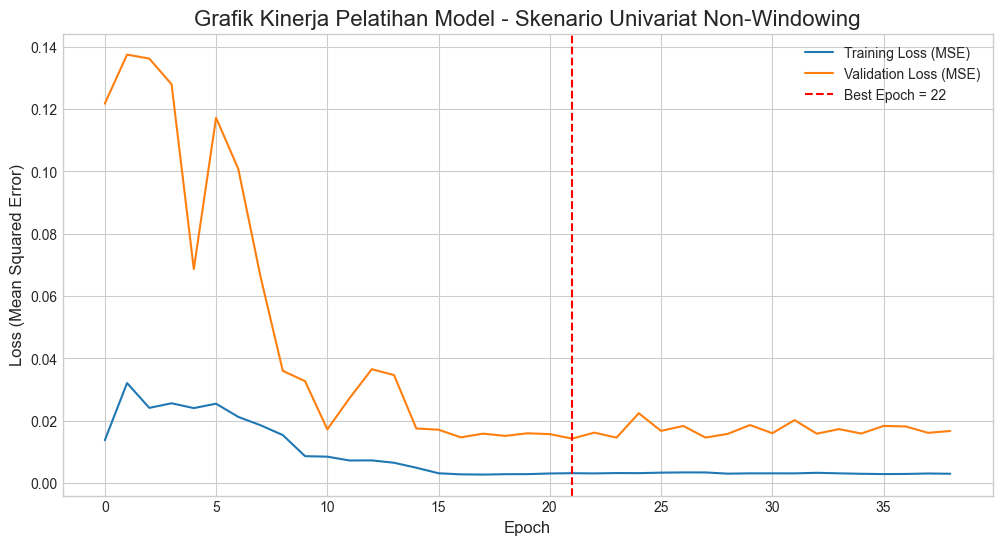


Memuat model terbaik dari file: final_model_univariate_nonwindowing.h5
Model terbaik berhasil dimuat.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import tensorflow as tf

# Tentukan nama file CSV hasil grid search untuk skenario ini
grid_search_results_file = 'grid_search_results_univariate_nonwindowing.csv'

try:
    # 1. Muat hasil grid search dari file CSV
    results_df = pd.read_csv(grid_search_results_file)
    print(f"Hasil grid search berhasil dimuat dari '{grid_search_results_file}'")

    # 2. Ambil hyperparameter terbaik dari baris pertama (diasumsikan sudah terurut)
    best_params_unw = results_df.iloc[0]
    print("\n--- Hyperparameter Terbaik Terpilih ---")
    print(best_params_unw.to_frame().T.to_string())
    print("-" * 50)

    # 3. Bangun dan Latih Model Final (sisa kode sama seperti sebelumnya)
    print("\nMembangun model final dengan hyperparameter terbaik...")
    final_model_unw = build_lstm_model(
        input_shape=(X_train_lstm_unw.shape[1], X_train_lstm_unw.shape[2]),
        output_size=y_train_unw.shape[1],
        num_units=int(best_params_unw['units']),
        dropout_rate=best_params_unw['dropout_rate'],
        learning_rate=best_params_unw['learning_rate']
    )
    final_model_unw.summary()

    # Definisikan callbacks
    final_model_path_unw = 'final_model_univariate_nonwindowing.h5'
    early_stopping_final = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
    model_checkpoint_final = ModelCheckpoint(filepath=final_model_path_unw, monitor='val_loss', save_best_only=True, verbose=1)
    # Ambil jumlah epoch terbaik dari hasil grid search
    best_epoch_from_search = int(best_params_unw['stopped_epoch'])

    # Latih model final
    print("\n--- Memulai Pelatihan Model Final ---")
    history_final_unw = final_model_unw.fit(
        X_train_lstm_unw, y_train_unw,
        epochs=best_epoch_from_search,
        batch_size=int(best_params_unw['batch_size']),
        validation_data=(X_val_lstm_unw, y_val_unw),
        callbacks=[model_checkpoint_final],
        verbose=1,
        shuffle=False
    )

    # Plot Grafik Kinerja Pelatihan
    print("\n--- Membuat Grafik Kinerja Pelatihan (Loss vs Epoch) ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))
    plt.plot(history_final_unw.history['loss'], label='Training Loss (MSE)')
    plt.plot(history_final_unw.history['val_loss'], label='Validation Loss (MSE)')
    plt.title('Grafik Kinerja Pelatihan Model - Skenario Univariat Non-Windowing', fontsize=16)
    plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    best_epoch = np.argmin(history_final_unw.history['val_loss']) + 1
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Epoch = {best_epoch}')
    plt.legend()
    plt.show()

    # Muat kembali model terbaik yang disimpan
    print(f"\nMemuat model terbaik dari file: {final_model_path_unw}")
    final_model_unw = load_model(
        final_model_path_unw, 
        custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
    )
    print("Model terbaik berhasil dimuat.")

except FileNotFoundError:
    print(f"ERROR: File hasil grid search '{grid_search_results_file}' tidak ditemukan.")
    print("Harap jalankan blok kode pencarian hyperparameter terlebih dahulu untuk menghasilkan file ini.")
except Exception as e:
    print(f"Terjadi error: {e}")

--- Memulai Evaluasi Final, Prediksi, dan Analisis Error (Univariat Non-Windowing) ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
- Test MSE (Skala Ternormalisasi): 0.059615
- Detail prediksi untuk 69 sampel disimpan ke 'detailed_predictions_univariate.csv'

--- Analisis Rata-rata Error per Hari Prediksi (30 Hari Horizon) ---

Rekapitulasi Rata-rata Error Kuadrat (MSE) per Hari (Test Set):
 Hari_Prediksi_ke  MSE (USD^2)
                1  171600384.0
                2  233123424.0
                3  191729184.0
                4  181237120.0
                5  179592944.0
                6  167052688.0
                7  231159504.0
                8  316746464.0
                9  258974288.0
               10  262942608.0
               11  516026496.0
               12  563607424.0
               13  377031424.0
               14  510397440.0
               15  531728352.0
               16  664922816.0
               17  590024896.0
               18  638135872.0
               19  856

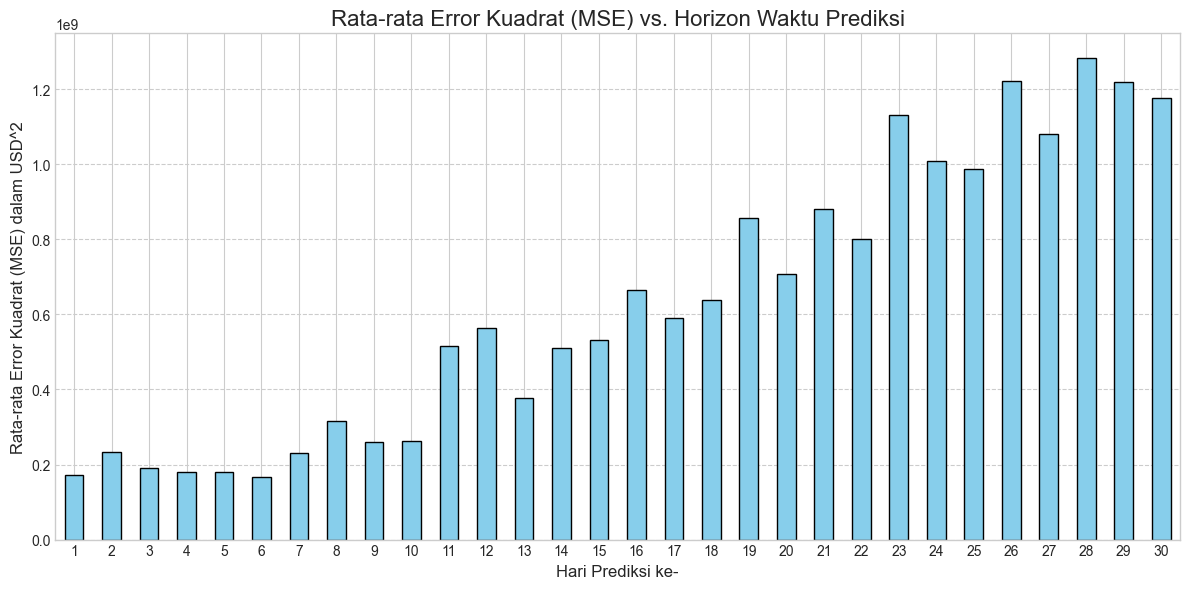


--- Visualisasi Grafik Sampel Prediksi vs Aktual ---


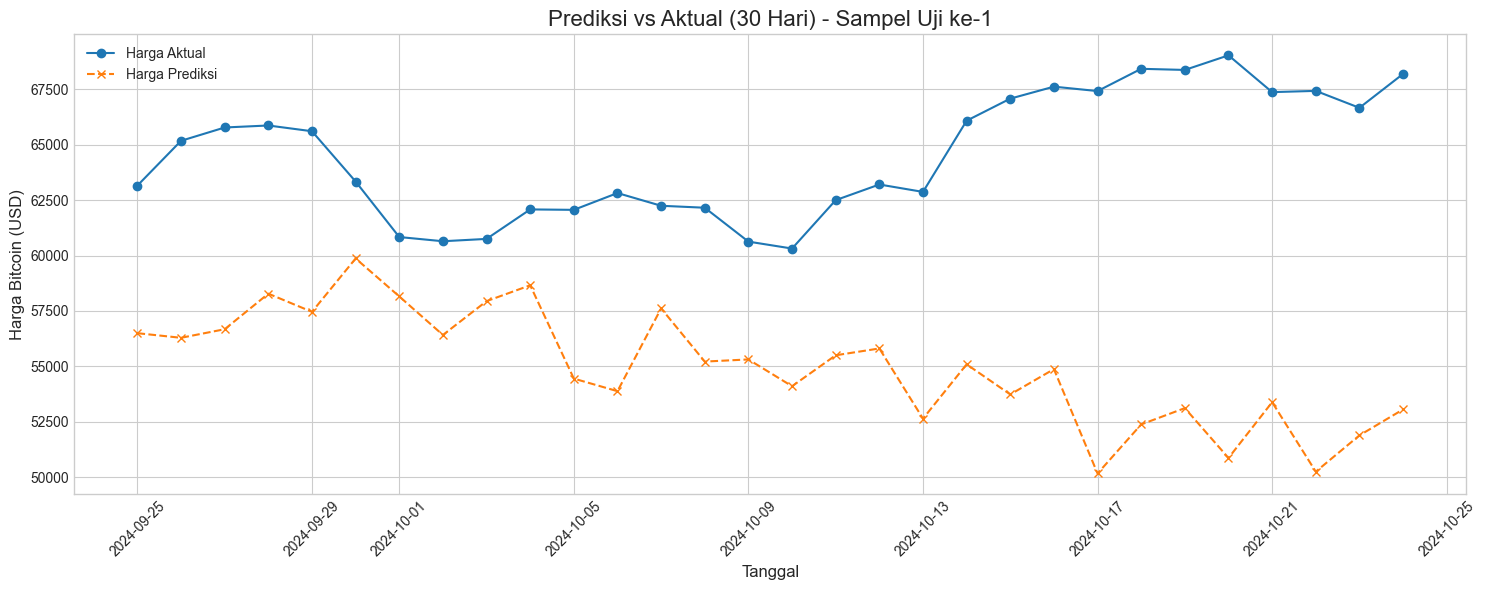

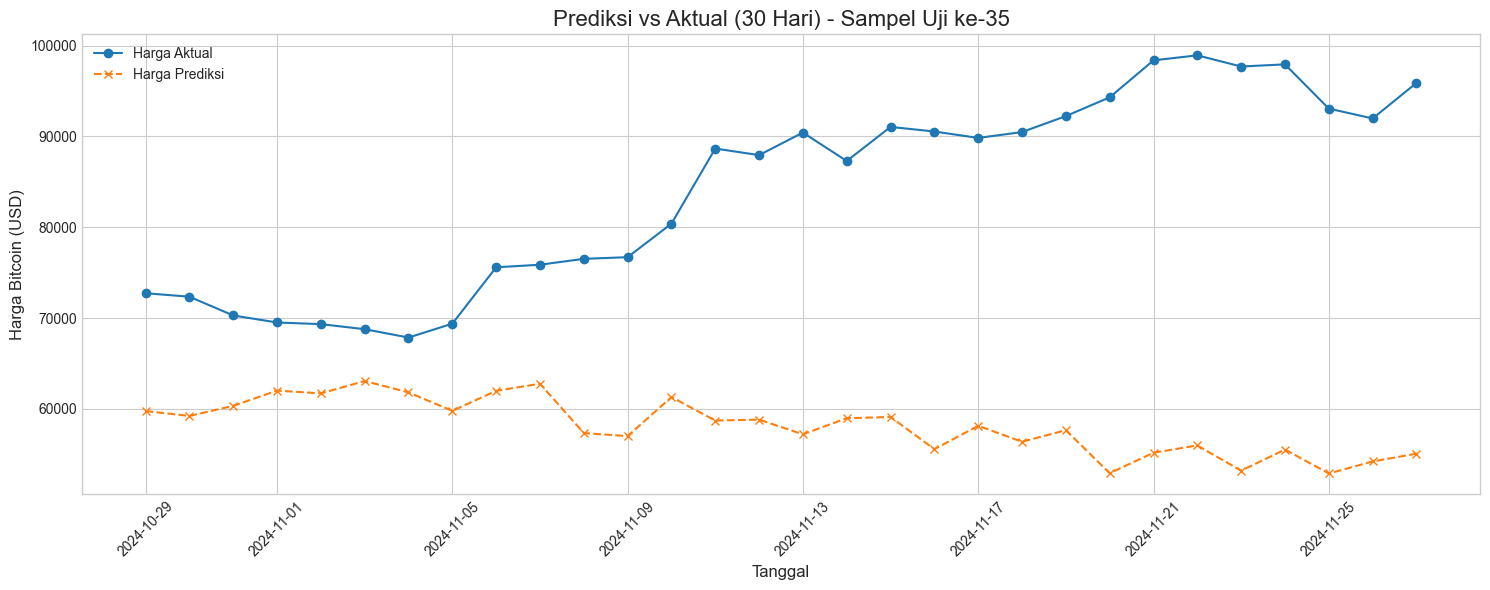

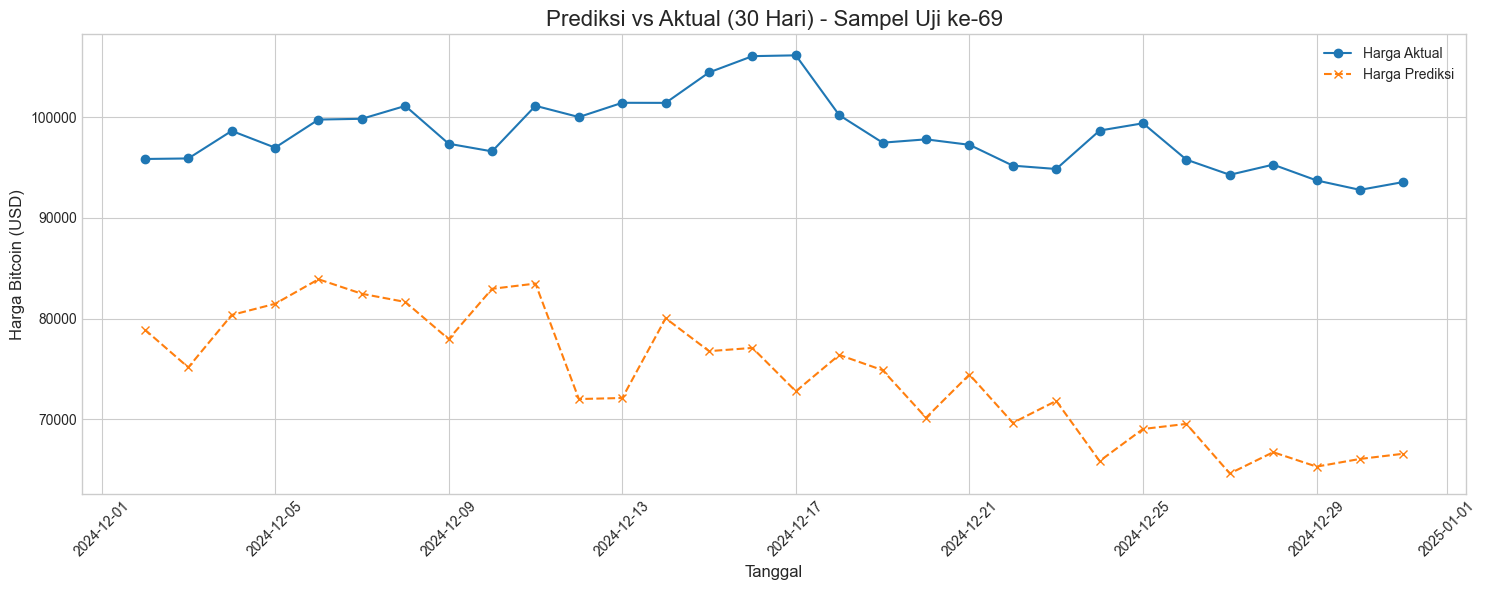

------------------------------
Proses untuk Skenario Univariat Non-Windowing Selesai.


In [9]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan variabel dari blok sebelumnya sudah ada
if 'final_model_unw' in locals() and 'X_test_lstm_unw' in locals():
    print("--- Memulai Evaluasi Final, Prediksi, dan Analisis Error (Univariat Non-Windowing) ---")

    try:
        # 1. Lakukan Prediksi dan Denormalisasi
        scaler_target_path = '../scaler_target.pkl'
        scaler_target = joblib.load(scaler_target_path)
        y_pred_scaled = final_model_unw.predict(X_test_lstm_unw)
        y_pred_denorm = scaler_target.inverse_transform(y_pred_scaled)
        y_test_denorm = scaler_target.inverse_transform(y_test_unw)
        
        # 2. Hitung MSE Keseluruhan pada Data Uji
        # mse_real_scale = mean_squared_error(y_test_denorm, y_pred_denorm)
        # print(f"\n- Test MSE Keseluruhan (Skala Asli USD^2): {mse_real_scale:,.2f}")
        mse_normalized = mean_squared_error(y_test_unw, y_pred_scaled)
        print(f"- Test MSE (Skala Ternormalisasi): {mse_normalized:.6f}")
        
        # 3. Simpan dan Analisis Detail Prediksi per Sampel
        all_predictions_list = []
        for i in range(len(X_test_lstm_unw)):
            start_date = pd.to_datetime(dates_X_test_unw[i]) + pd.Timedelta(days=1)
            date_range = pd.date_range(start=start_date, periods=N_OUTPUT_DAYS)
            
            sample_df = pd.DataFrame({
                'Sample_Uji_ke': i + 1,
                'Hari_Prediksi_ke': np.arange(1, N_OUTPUT_DAYS + 1),
                'Tanggal': date_range,
                'Harga_Aktual': y_test_denorm[i],
                'Harga_Prediksi': y_pred_denorm[i]
            })
            all_predictions_list.append(sample_df)
            
        all_predictions_df = pd.concat(all_predictions_list, ignore_index=True)
        # REVISI: Hitung error kuadrat untuk MSE
        all_predictions_df['Error_Kuadrat'] = (all_predictions_df['Harga_Prediksi'] - all_predictions_df['Harga_Aktual'])**2
        
        output_predictions_file = 'detailed_predictions_univariate.csv'
        all_predictions_df.to_csv(output_predictions_file, index=False, float_format='%.2f')
        print(f"- Detail prediksi untuk {len(X_test_lstm_unw)} sampel disimpan ke '{output_predictions_file}'")

        # 4. Analisis Rata-rata Error Kuadrat (MSE) per Hari Prediksi
        print("\n--- Analisis Rata-rata Error per Hari Prediksi (30 Hari Horizon) ---")
        # REVISI: Menghitung MSE per hari
        mse_per_day = all_predictions_df.groupby('Hari_Prediksi_ke')['Error_Kuadrat'].mean()
        
        min_error_day = mse_per_day.idxmin()
        max_error_day = mse_per_day.idxmax()
        
        print("\nRekapitulasi Rata-rata Error Kuadrat (MSE) per Hari (Test Set):")
        print(mse_per_day.to_frame(name='MSE (USD^2)').reset_index().to_string(index=False))
        
        print("\n--- Analisis Rekap Error ---")
        print(f"- Prediksi paling akurat (MSE terendah) terjadi pada : Hari ke-{min_error_day}")
        print(f"- Prediksi paling tidak akurat (MSE tertinggi) terjadi pada: Hari ke-{max_error_day}")
        
        # Visualisasi Kurva Error
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(12, 6))
        mse_per_day.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title('Rata-rata Error Kuadrat (MSE) vs. Horizon Waktu Prediksi', fontsize=16)
        plt.xlabel('Hari Prediksi ke-', fontsize=12)
        plt.ylabel('Rata-rata Error Kuadrat (MSE) dalam USD^2', fontsize=12)
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

        # 5. Visualisasi Grafik Sampel (Tidak ada perubahan di sini)
        print("\n--- Visualisasi Grafik Sampel Prediksi vs Aktual ---")
        sample_indices_to_plot = [0, len(X_test_lstm_unw) // 2, len(X_test_lstm_unw) - 1]
        for sample_index in sample_indices_to_plot:
            plot_df = all_predictions_df[all_predictions_df['Sample_Uji_ke'] == sample_index + 1]
            plt.figure(figsize=(15, 6))
            plt.plot(plot_df['Tanggal'], plot_df['Harga_Aktual'], label='Harga Aktual', marker='o')
            plt.plot(plot_df['Tanggal'], plot_df['Harga_Prediksi'], label='Harga Prediksi', marker='x', linestyle='--')
            plt.title(f'Prediksi vs Aktual (30 Hari) - Sampel Uji ke-{sample_index+1}', fontsize=16)
            plt.ylabel('Harga Bitcoin (USD)', fontsize=12)
            plt.xlabel('Tanggal', fontsize=12)
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Terjadi error pada proses evaluasi atau visualisasi: {e}")
else:
    print("Model atau data uji tidak tersedia untuk dievaluasi.")

print("-" * 30)
print("Proses untuk Skenario Univariat Non-Windowing Selesai.")

In [10]:
# Simpan data rata-rata error per hari prediksi (MSE) ke CSV
mse_per_day_df = mse_per_day.reset_index()
mse_per_day_df.columns = ['Hari_Prediksi_ke', 'MSE (USD^2)']
mse_per_day_df.to_csv('mse_per_day_univariate.csv', index=False, float_format='%.2f')
print("Data rata-rata error per hari prediksi (MSE) telah disimpan ke 'mse_per_day_univariate.csv'")

Data rata-rata error per hari prediksi (MSE) telah disimpan ke 'mse_per_day_univariate.csv'
